In [ ]:
import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path_data = '/content/drive/MyDrive/Diabetic Retinopathy Dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Dataset/Healthy')
Mild = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Dataset/Mild DR')
Moderate = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Dataset/Moderate DR')
Proliferate = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Dataset/Proliferate DR')
Severe = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Dataset/Severe DR')

In [ ]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Proliferate DR', 'Severe DR', 'Healthy', 'Mild DR', 'Moderate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [ ]:
# Get Paths

Path_data = '/content/drive/MyDrive/Diabetic Retinopathy Dataset'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/content/drive/MyDrive/Diabetic Retinopathy Da...,Proliferate DR
1,/content/drive/MyDrive/Diabetic Retinopathy Da...,Proliferate DR
2,/content/drive/MyDrive/Diabetic Retinopathy Da...,Proliferate DR
3,/content/drive/MyDrive/Diabetic Retinopathy Da...,Proliferate DR
4,/content/drive/MyDrive/Diabetic Retinopathy Da...,Proliferate DR


In [ ]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           799
Moderate DR       723
Mild DR           290
Proliferate DR    232
Severe DR         156
Name: count, dtype: int64

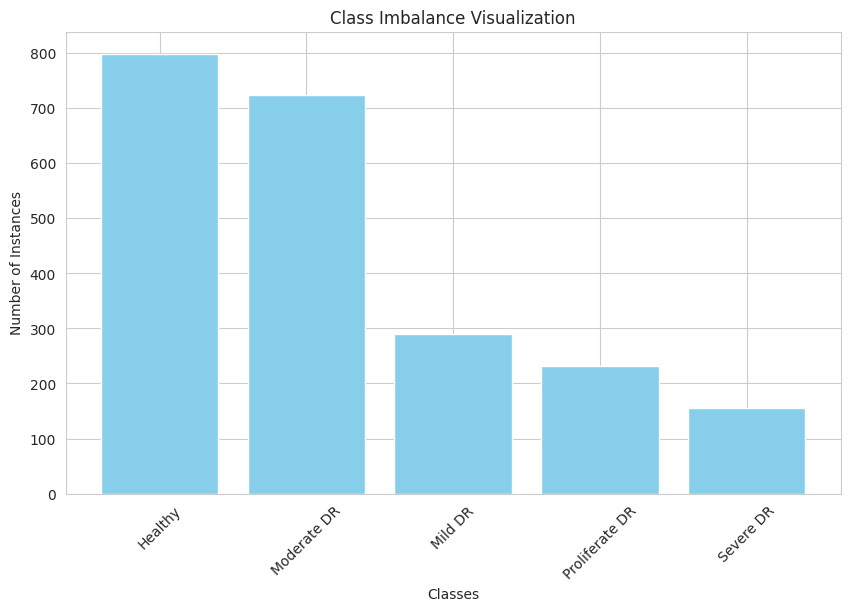

In [ ]:
# Plot class imbalance histogram
import matplotlib.pyplot as plt

# Count the number of instances for each class
class_counts = train['Labels'].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Class Imbalance Visualization')
plt.xticks(rotation=45)
plt.show()

In [ ]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest'
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


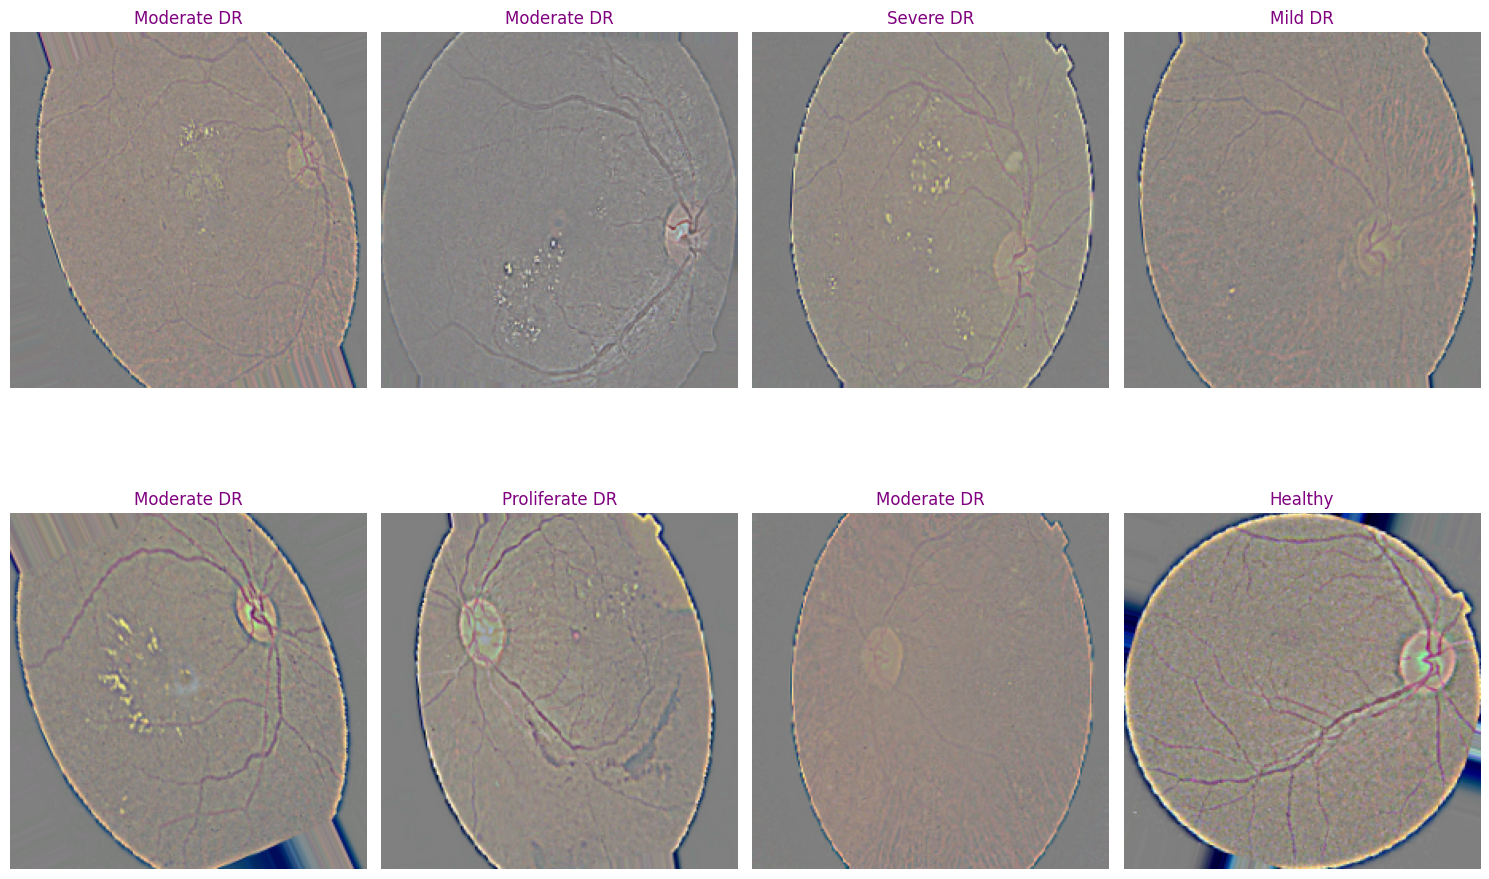

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model1= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model1.trainable=True
x=base_model1.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output1=Dense(n_classes, activation='softmax')(x)
model1=Model(inputs=base_model1.input, outputs=output1)
lr=.0001 # start with this learning rate

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
model1=Sequential()
model1.add(base_model1)
model1.add(Dropout(0.3))
model1.add(Flatten())
model1.add(Dense(512, activation='elu'))
model1.add(Dense(256, activation='elu'))
model1.add(Dense(128, activation = 'elu'))
model1.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.applications import InceptionV3
model_name='InceptionV3'
base_model2= InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model2.trainable=True
x=base_model2.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output2=Dense(n_classes, activation='softmax')(x)
model2=Model(inputs=base_model2.input, outputs=output2)
lr=.0001 # start with this learning rate

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model2=Sequential()
model2.add(base_model2)
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(512, activation='elu'))
model2.add(Dense(256, activation='elu'))
model2.add(Dense(128, activation = 'elu'))
model2.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.applications import DenseNet121
model_name='DenseNet121'
base_model3= DenseNet121(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model3.trainable=True
x=base_model3.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output3=Dense(n_classes, activation='softmax')(x)
model3=Model(inputs=base_model3.input, outputs=output3)
lr=.0001 # start with this learning rate

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model3=Sequential()
model3.add(base_model3)
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(512, activation='elu'))
model3.add(Dense(256, activation='elu'))
model3.add(Dense(128, activation = 'elu'))
model3.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.applications import ResNet50
model_name='ResNet50'
base_model4= ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model4.trainable=True
x=base_model4.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output4=Dense(n_classes, activation='softmax')(x)
model4=Model(inputs=base_model4.input, outputs=output4)
lr=.0001 # start with this learning rate

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model4=Sequential()
model4.add(base_model4)
model4.add(Dropout(0.3))
model4.add(Flatten())
model4.add(Dense(512, activation='elu'))
model4.add(Dense(256, activation='elu'))
model4.add(Dense(128, activation = 'elu'))
model4.add(Dense(5, activation='softmax'))

In [ ]:
model1.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model2.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model3.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model4.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
epochs = 50
history1 = model1.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
110/110 [==============================] - 1008s 9s/step - loss: 1.7225 - acc: 0.4732 - val_loss: 1.3327 - val_acc: 0.5455
Epoch 2/50
110/110 [==============================] - 52s 474ms/step - loss: 1.1891 - acc: 0.5686 - val_loss: 1.0256 - val_acc: 0.6473
Epoch 3/50
110/110 [==============================] - 53s 483ms/step - loss: 1.0637 - acc: 0.6095 - val_loss: 0.9178 - val_acc: 0.6291
Epoch 4/50
110/110 [==============================] - 52s 471ms/step - loss: 0.9701 - acc: 0.6264 - val_loss: 0.9138 - val_acc: 0.6400
Epoch 5/50
110/110 [==============================] - 55s 496ms/step - loss: 0.9251 - acc: 0.6577 - val_loss: 0.8942 - val_acc: 0.6473
Epoch 6/50
110/110 [==============================] - 52s 469ms/step - loss: 0.8949 - acc: 0.6623 - val_loss: 0.9361 - val_acc: 0.6582
Epoch 7/50
110/110 [==============================] - 50s 454ms/step - loss: 0.8413 - acc: 0.6777 - val_loss: 0.8657 - val_acc: 0.6691
Epoch 8/50
110/110 [==============================] - 52

In [ ]:
# accuracy and loss of Train

tr_acc = history1.history['acc']
tr_loss = history1.history['loss']


# accuracy and loss or Valid\

v_acc = history1.history['val_acc']
v_loss = history1.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

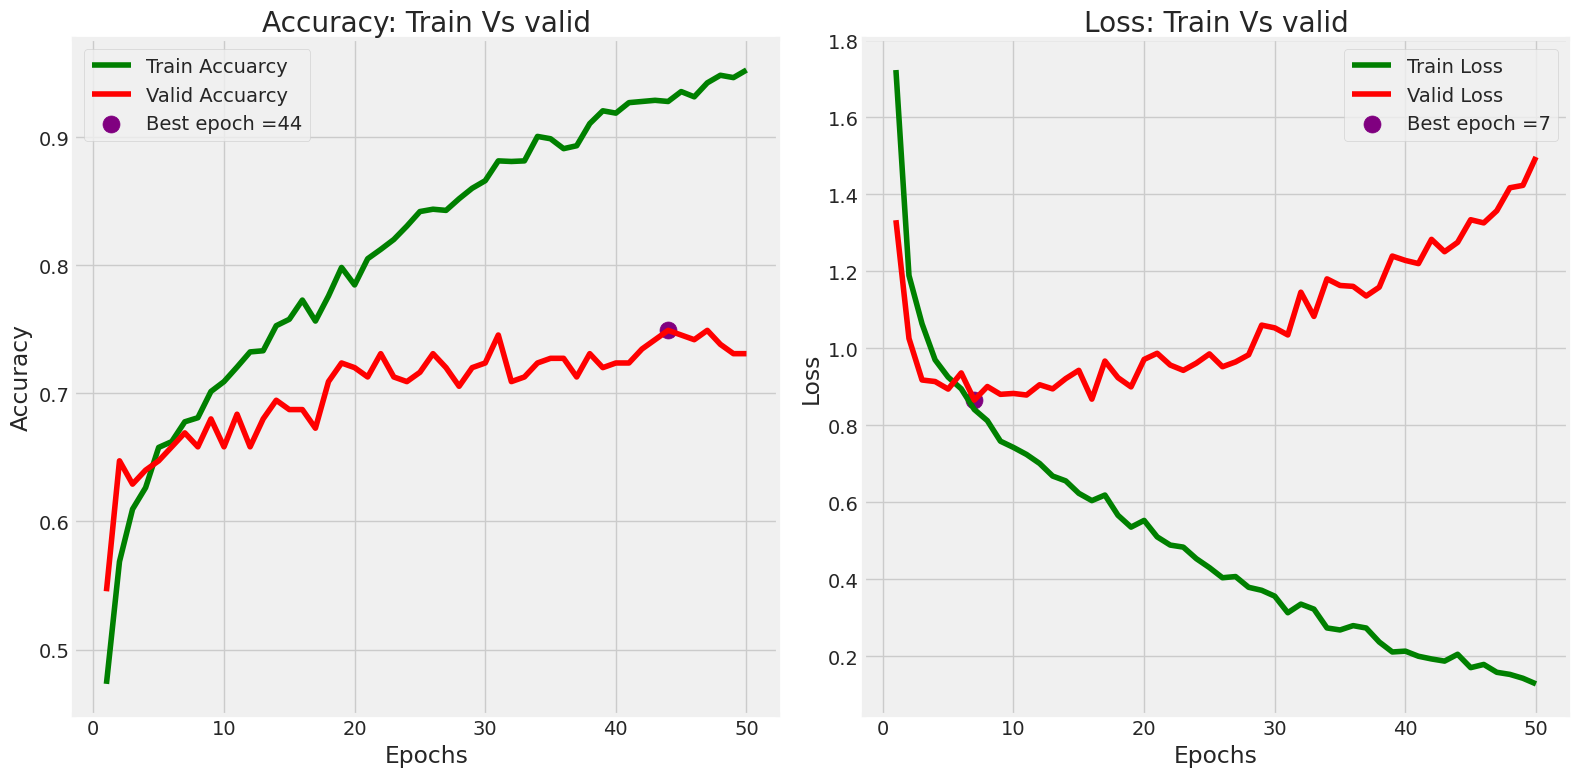

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model1.evaluate(Train, verbose = 1)
Valid_sc = model1.evaluate(Valid, verbose = 1)
Test_sc =model1.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 95s 7s/step - loss: 1.1945 - acc: 0.7200
Train Scores : 
    accuracy: 0.9845454692840576 
      Loss:  0.04571764916181564 
________________________
Valid Scores : 
    accuracy: 0.7309091091156006 
      Loss:  1.496765375137329 
________________________
Test Scores : 
    accuracy: 0.7200000286102295 
      Loss:  1.1944721937179565 
________________________


In [ ]:
predictions = model1.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[3.2011798e-05 5.6619750e-04 5.0902314e-02 8.0138788e-04 9.4769806e-01]
 [6.8023151e-06 1.5322656e-04 1.4615971e-01 3.6813673e-03 8.4999895e-01]
 [9.9978501e-01 8.8799825e-05 1.2560352e-04 6.4528928e-07 3.8500612e-09]
 ...
 [3.4655793e-06 1.6959233e-05 4.0295181e-01 1.5865286e-03 5.9544128e-01]
 [9.9999082e-01 1.0770261e-06 7.8563453e-06 2.4487977e-07 1.5203218e-09]
 [2.8546157e-01 3.4355349e-04 7.1419382e-01 7.7512499e-07 2.7885133e-07]]
[4 4 0 2 2 0 1 1 0 0 2 0 3 0 3 2 2 2 1 0 0 4 3 2 1 1 2 2 2 1 1 0 0 1 0 0 1
 1 1 2 0 3 2 0 2 0 0 1 0 0 1 2 2 4 2 0 0 1 0 0 0 1 1 1 0 0 2 0 3 1 0 1 0 1
 4 2 3 2 4 0 2 2 1 2 2 2 2 0 1 2 0 2 2 2 0 2 2 2 1 0 2 2 4 2 2 0 2 2 2 1 2
 0 2 3 0 1 0 2 1 2 4 2 0 2 2 1 1 0 1 2 0 2 0 2 2 1 0 0 0 0 2 0 2 0 4 3 0 0
 3 2 2 4 0 0 2 0 0 2 1 2 2 2 2 0 2 0 0 0 2 1 3 4 2 0 2 3 0 0 3 1 0 0 0 2 0
 2 0 0 2 2 2 0 3 2 2 0 2 2 2 2 1 2 0 2 0 2 2 1 1 0 2 0 1 1 4 0 1 0 2 0 3 0
 2 0 1 2 3 0 4 0 0 4 0 0 0 3 4 0 2 2 0 0 0 0 1 0 0 0 4 0 0 2 1 2 0 0 0 0 1
 3 2 4 2 2 2 1 2 2 0 2 2 1 4 0 

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[94,  1,  0,  0,  0],
       [ 1, 26, 14,  2,  0],
       [ 3, 14, 63,  5,  5],
       [ 1,  2, 13,  7,  5],
       [ 0,  2,  6,  3,  8]])

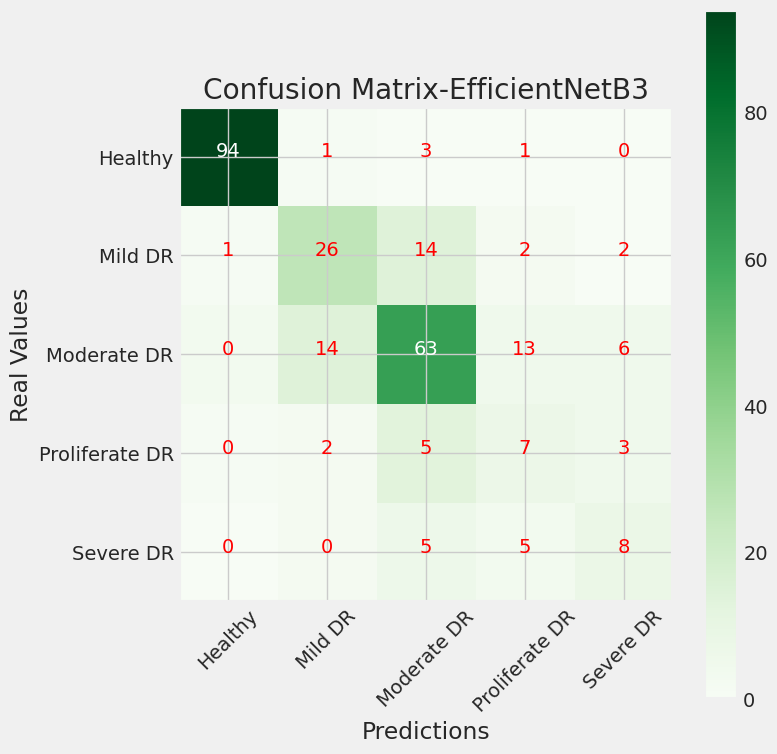

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix-EfficientNetB3")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Classification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.95      0.99      0.97        95
       Mild DR       0.58      0.60      0.59        43
   Moderate DR       0.66      0.70      0.68        90
Proliferate DR       0.41      0.25      0.31        28
     Severe DR       0.44      0.42      0.43        19

      accuracy                           0.72       275
     macro avg       0.61      0.59      0.60       275
  weighted avg       0.71      0.72      0.71       275



In [ ]:
model1.save('model1.h5')

In [ ]:
epochs = 50
history2 = model2.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
110/110 [==============================] - 83s 427ms/step - loss: 1.2846 - acc: 0.5395 - val_loss: 1.3631 - val_acc: 0.4727
Epoch 2/50
110/110 [==============================] - 47s 424ms/step - loss: 0.9772 - acc: 0.6364 - val_loss: 1.0604 - val_acc: 0.6364
Epoch 3/50
110/110 [==============================] - 44s 400ms/step - loss: 0.8702 - acc: 0.6673 - val_loss: 0.8820 - val_acc: 0.6945
Epoch 4/50
110/110 [==============================] - 44s 402ms/step - loss: 0.8167 - acc: 0.6900 - val_loss: 0.8801 - val_acc: 0.7018
Epoch 5/50
110/110 [==============================] - 46s 422ms/step - loss: 0.7907 - acc: 0.7041 - val_loss: 0.8222 - val_acc: 0.7127
Epoch 6/50
110/110 [==============================] - 44s 399ms/step - loss: 0.7598 - acc: 0.7023 - val_loss: 0.8177 - val_acc: 0.7055
Epoch 7/50
110/110 [==============================] - 44s 401ms/step - loss: 0.7216 - acc: 0.7245 - val_loss: 0.8751 - val_acc: 0.6727
Epoch 8/50
110/110 [==============================] - 4

In [ ]:
# accuracy and loss of Train

tr_acc = history2.history['acc']
tr_loss = history2.history['loss']


# accuracy and loss or Valid\

v_acc = history2.history['val_acc']
v_loss = history2.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

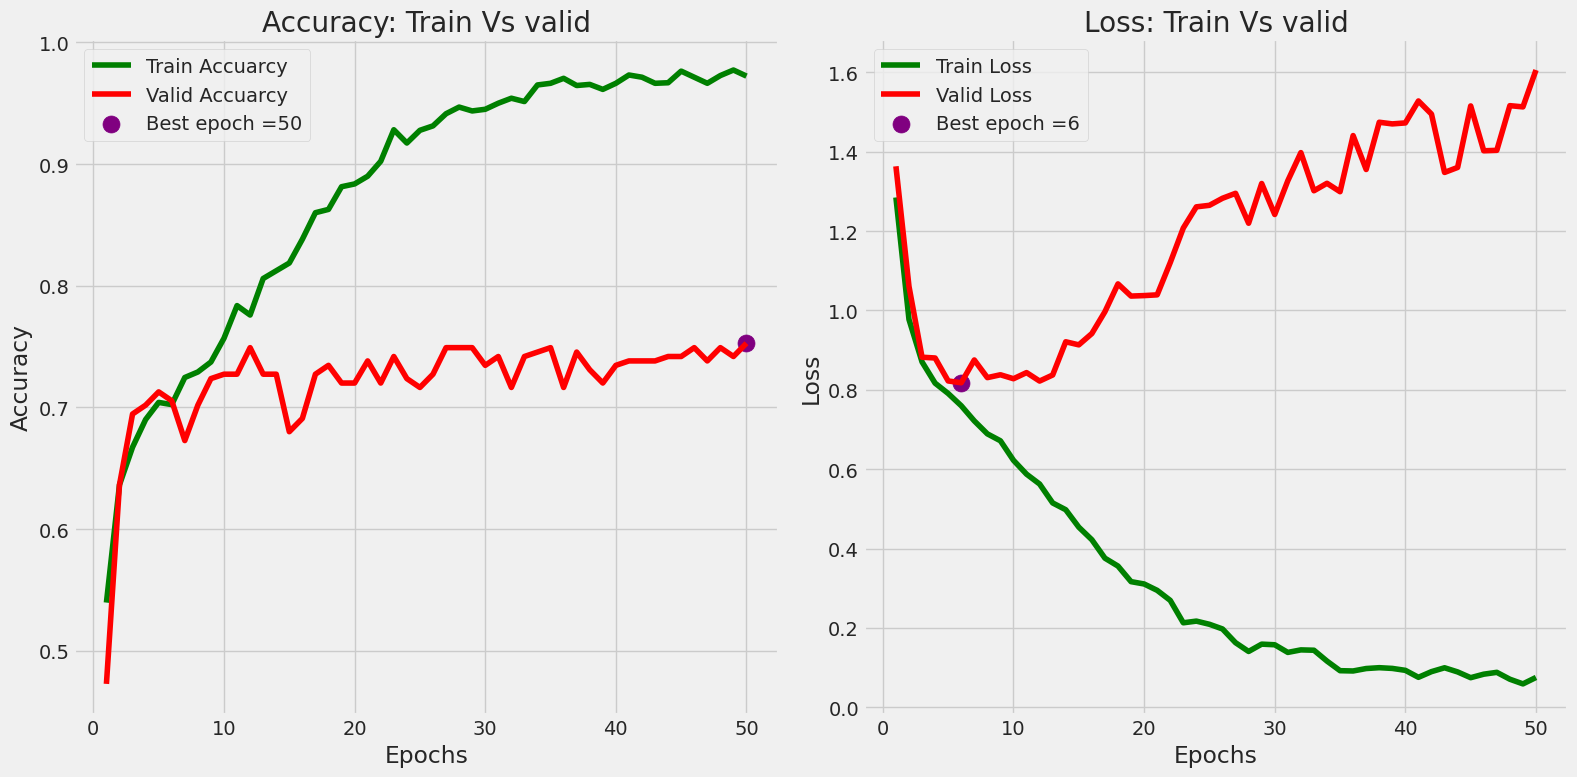

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model2.evaluate(Train, verbose = 1)
Valid_sc = model2.evaluate(Valid, verbose = 1)
Test_sc =model2.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 2s 146ms/step - loss: 1.6046 - acc: 0.7200
Train Scores : 
    accuracy: 0.9904545545578003 
      Loss:  0.030695121735334396 
________________________
Valid Scores : 
    accuracy: 0.7527272701263428 
      Loss:  1.605645775794983 
________________________
Test Scores : 
    accuracy: 0.7200000286102295 
      Loss:  1.6045901775360107 
________________________


In [ ]:
predictions = model2.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[4.20710755e-08 1.17781701e-05 9.13061900e-04 8.12689832e-05
  9.98993814e-01]
 [7.34980347e-07 5.35962754e-04 9.99325633e-01 1.04995925e-04
  3.27845737e-05]
 [9.99999881e-01 7.91294568e-08 1.95143208e-08 8.08745426e-09
  9.40970002e-15]
 ...
 [8.02667977e-09 5.68540190e-06 9.99561727e-01 4.31587250e-04
  9.75819376e-07]
 [9.99985933e-01 1.44052478e-06 8.90252159e-06 3.60396962e-06
  8.93730530e-08]
 [6.89527765e-02 9.28750694e-01 1.95712061e-03 3.18970153e-04
  2.04324751e-05]]
[4 2 0 2 3 0 1 1 0 0 2 0 3 0 3 2 2 2 1 0 0 4 2 2 1 1 2 2 4 2 1 0 0 3 0 0 2
 0 2 2 0 4 1 0 2 0 0 1 0 0 1 2 2 3 2 0 0 1 2 0 0 1 2 2 0 0 2 0 3 1 0 1 0 1
 2 2 3 2 3 0 1 1 1 2 4 2 4 0 1 3 0 2 2 2 2 1 2 1 2 0 2 2 1 2 3 0 2 2 2 2 2
 0 2 1 0 1 0 2 1 2 4 2 0 2 2 1 2 0 3 2 0 4 1 2 1 2 0 0 0 0 2 0 3 0 2 4 0 0
 3 3 2 2 0 0 2 0 0 2 1 2 1 2 2 0 2 0 0 0 2 2 2 4 2 0 3 3 0 0 3 1 0 0 0 2 0
 2 0 0 3 1 2 0 3 2 3 3 2 2 2 2 1 4 0 2 0 2 3 1 3 0 2 0 2 2 4 0 2 0 2 0 3 0
 2 0 1 2 3 0 4 0 0 4 0 0 0 3 2 0 2 2 0 0 0 0 1 2 0 0 2 0 0 2 1 2

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[92,  2,  1,  0,  0],
       [ 1, 23, 16,  3,  0],
       [ 2,  9, 65,  9,  5],
       [ 0,  4, 10, 11,  3],
       [ 0,  1,  8,  3,  7]])

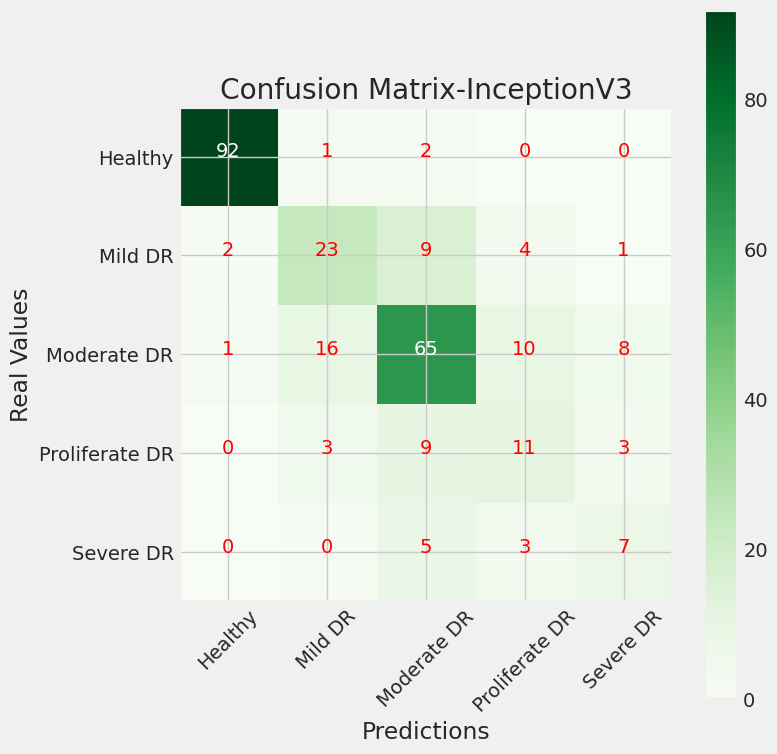

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix-InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Classification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.97      0.97      0.97        95
       Mild DR       0.59      0.53      0.56        43
   Moderate DR       0.65      0.72      0.68        90
Proliferate DR       0.42      0.39      0.41        28
     Severe DR       0.47      0.37      0.41        19

      accuracy                           0.72       275
     macro avg       0.62      0.60      0.61       275
  weighted avg       0.71      0.72      0.72       275



In [ ]:
model2.save('model2.h5')

In [ ]:
epochs = 50
history3 = model3.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
110/110 [==============================] - 112s 469ms/step - loss: 1.6849 - acc: 0.5045 - val_loss: 1.3208 - val_acc: 0.5818
Epoch 2/50
110/110 [==============================] - 48s 438ms/step - loss: 1.1640 - acc: 0.5823 - val_loss: 1.0750 - val_acc: 0.6545
Epoch 3/50
110/110 [==============================] - 47s 423ms/step - loss: 0.9973 - acc: 0.6386 - val_loss: 0.9723 - val_acc: 0.7055
Epoch 4/50
110/110 [==============================] - 49s 448ms/step - loss: 0.9337 - acc: 0.6541 - val_loss: 0.9438 - val_acc: 0.6545
Epoch 5/50
110/110 [==============================] - 47s 424ms/step - loss: 0.8808 - acc: 0.6686 - val_loss: 0.8854 - val_acc: 0.6655
Epoch 6/50
110/110 [==============================] - 48s 436ms/step - loss: 0.8222 - acc: 0.6923 - val_loss: 0.8938 - val_acc: 0.6982
Epoch 7/50
110/110 [==============================] - 48s 435ms/step - loss: 0.7719 - acc: 0.7005 - val_loss: 0.8102 - val_acc: 0.7018
Epoch 8/50
110/110 [==============================] - 

In [ ]:
# accuracy and loss of Train

tr_acc = history3.history['acc']
tr_loss = history3.history['loss']


# accuracy and loss or Valid\

v_acc = history3.history['val_acc']
v_loss = history3.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

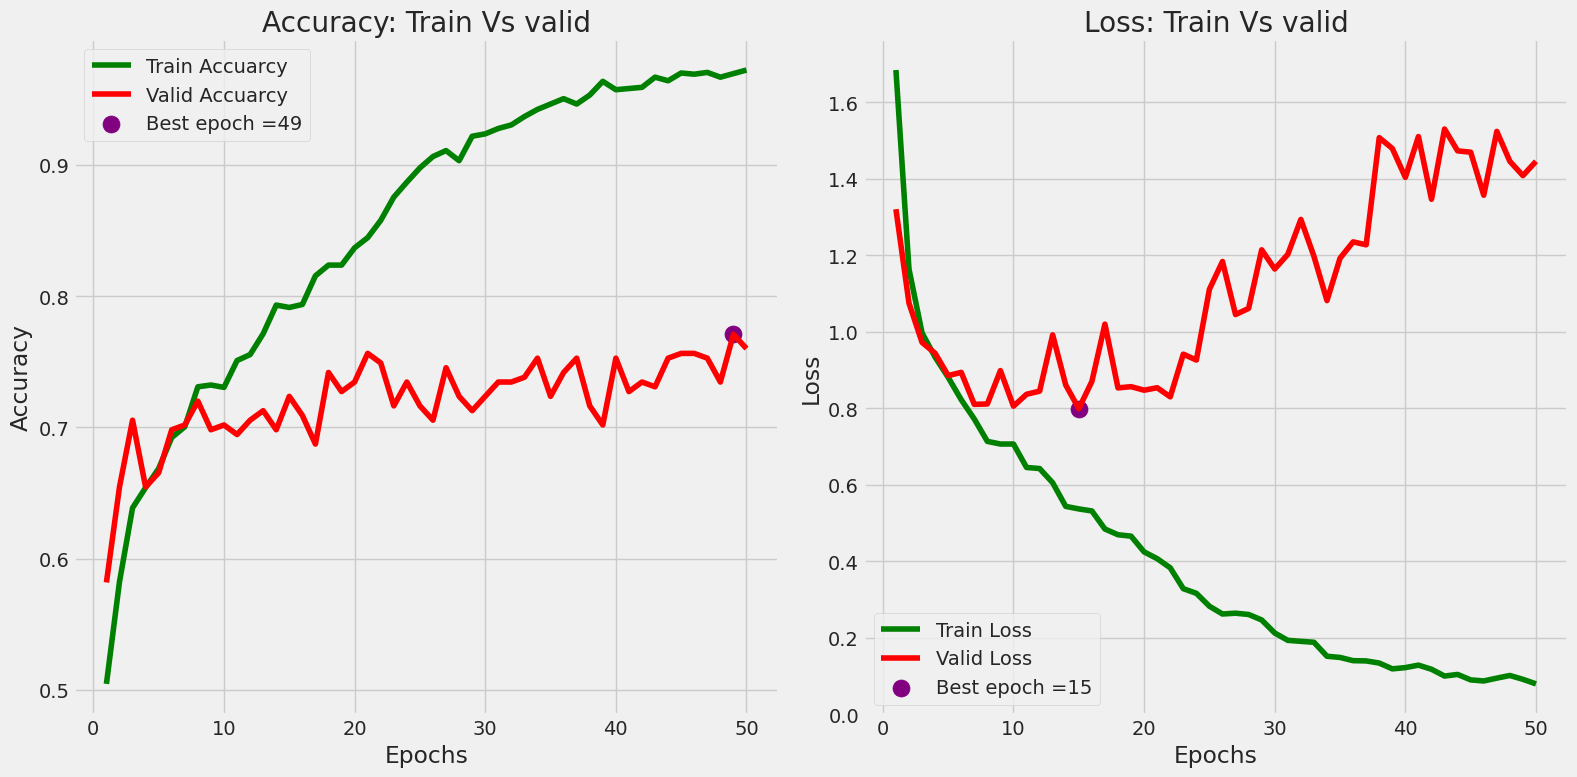

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model3.evaluate(Train, verbose = 1)
Valid_sc = model3.evaluate(Valid, verbose = 1)
Test_sc =model3.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 2s 151ms/step - loss: 1.3241 - acc: 0.7018
Train Scores : 
    accuracy: 0.9927272796630859 
      Loss:  0.027193566784262657 
________________________
Valid Scores : 
    accuracy: 0.7599999904632568 
      Loss:  1.4459871053695679 
________________________
Test Scores : 
    accuracy: 0.7018181681632996 
      Loss:  1.3240959644317627 
________________________


In [ ]:
predictions = model3.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[6.0652297e-08 2.8414382e-07 1.3267577e-02 1.3015253e-03 9.8543060e-01]
 [9.1318405e-05 3.0544871e-03 4.9129176e-01 1.8910619e-03 5.0367135e-01]
 [9.9999964e-01 2.0655649e-07 7.7321182e-08 1.2484682e-12 1.3963418e-12]
 ...
 [2.3009856e-09 2.8596688e-07 9.9881113e-01 6.6943579e-07 1.1879009e-03]
 [9.9793279e-01 2.0336879e-03 3.3533073e-05 1.7981760e-08 1.5554430e-09]
 [9.0584683e-04 3.1482019e-03 9.9560332e-01 1.8898869e-04 1.5371869e-04]]
[4 4 0 2 1 0 1 1 0 0 2 0 3 0 2 2 2 4 1 0 0 2 2 2 1 2 2 2 2 2 1 0 0 1 0 0 1
 0 1 3 0 4 1 1 2 0 0 1 0 0 1 2 1 4 2 0 0 1 2 0 0 1 1 2 0 0 2 0 3 1 0 1 0 2
 2 2 3 2 4 0 2 1 1 2 2 2 2 0 3 2 0 1 2 2 1 1 2 2 1 0 1 2 3 2 2 0 2 2 2 2 2
 0 2 3 0 1 0 2 1 2 4 3 0 2 2 1 1 0 3 2 0 4 0 2 2 3 0 0 0 0 2 0 3 0 2 3 0 0
 3 2 2 0 0 0 2 0 0 2 1 2 1 2 2 0 2 0 0 0 4 2 2 2 2 0 2 2 0 0 2 1 0 0 0 2 0
 3 0 0 1 2 2 0 2 2 3 3 1 2 2 2 1 2 0 2 0 2 2 1 2 0 2 1 1 2 4 0 1 0 2 0 3 0
 2 0 1 2 3 0 4 1 0 2 0 0 0 2 2 0 2 2 0 0 0 0 3 2 0 0 4 0 0 1 1 2 0 0 0 0 1
 1 2 4 2 2 2 1 3 2 0 2 2 1 2 0 

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[90,  5,  0,  0,  0],
       [ 1, 26, 14,  2,  0],
       [ 2, 16, 62,  4,  6],
       [ 0,  1, 11, 12,  4],
       [ 1,  0, 13,  2,  3]])

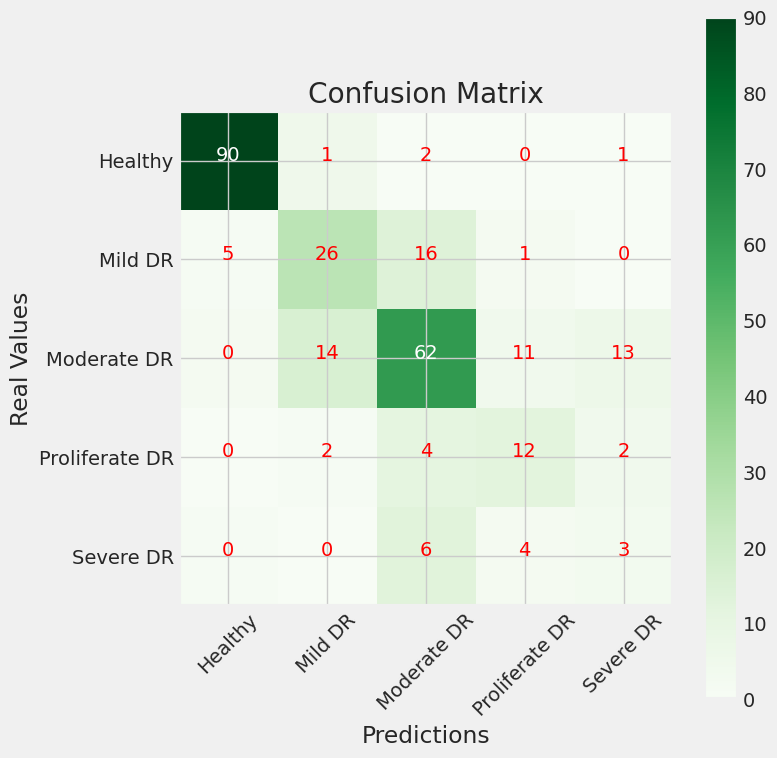

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Classification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.96      0.95      0.95        95
       Mild DR       0.54      0.60      0.57        43
   Moderate DR       0.62      0.69      0.65        90
Proliferate DR       0.60      0.43      0.50        28
     Severe DR       0.23      0.16      0.19        19

      accuracy                           0.70       275
     macro avg       0.59      0.57      0.57       275
  weighted avg       0.70      0.70      0.70       275



In [ ]:
model3.save('model3.h5')

In [ ]:
epochs = 50
history4 = model4.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
110/110 [==============================] - 80s 444ms/step - loss: 2.2705 - acc: 0.5250 - val_loss: 1.5027 - val_acc: 0.5564
Epoch 2/50
110/110 [==============================] - 47s 427ms/step - loss: 1.3685 - acc: 0.6050 - val_loss: 1.2177 - val_acc: 0.6655
Epoch 3/50
110/110 [==============================] - 47s 423ms/step - loss: 1.1724 - acc: 0.6295 - val_loss: 0.9665 - val_acc: 0.6655
Epoch 4/50
110/110 [==============================] - 49s 442ms/step - loss: 1.0357 - acc: 0.6623 - val_loss: 0.9801 - val_acc: 0.6582
Epoch 5/50
110/110 [==============================] - 47s 426ms/step - loss: 0.9264 - acc: 0.6759 - val_loss: 1.0280 - val_acc: 0.6800
Epoch 6/50
110/110 [==============================] - 47s 424ms/step - loss: 0.8696 - acc: 0.7005 - val_loss: 0.9614 - val_acc: 0.6582
Epoch 7/50
110/110 [==============================] - 49s 441ms/step - loss: 0.7637 - acc: 0.7241 - val_loss: 0.9197 - val_acc: 0.6873
Epoch 8/50
110/110 [==============================] - 4

In [ ]:
# accuracy and loss of Train

tr_acc = history4.history['acc']
tr_loss = history4.history['loss']


# accuracy and loss or Valid\

v_acc = history4.history['val_acc']
v_loss = history4.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

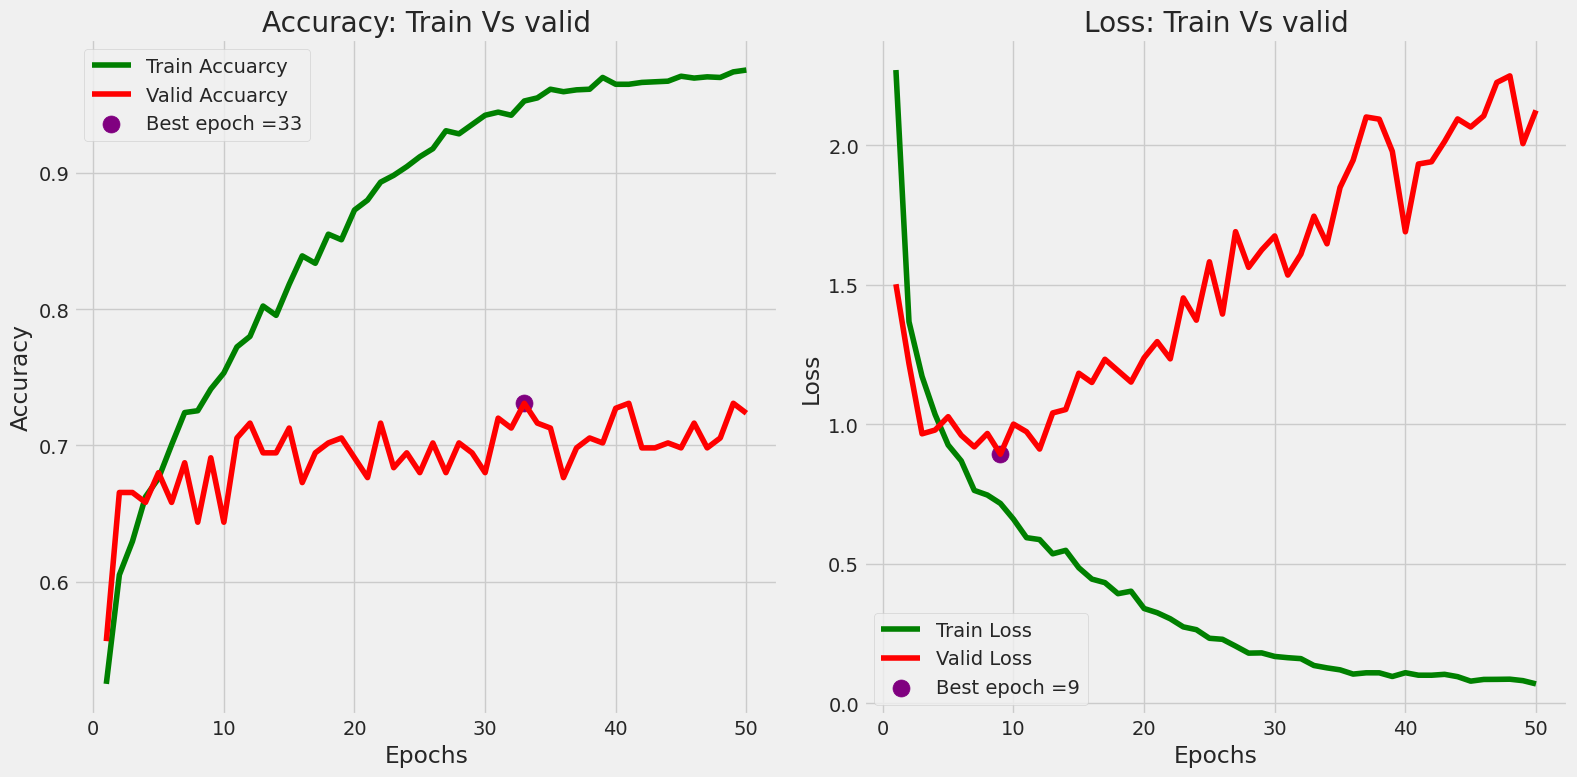

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model4.evaluate(Train, verbose = 1)
Valid_sc = model4.evaluate(Valid, verbose = 1)
Test_sc =model4.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 2s 122ms/step - loss: 1.7526 - acc: 0.7200
Train Scores : 
    accuracy: 0.9886363744735718 
      Loss:  0.03737213835120201 
________________________
Valid Scores : 
    accuracy: 0.7236363887786865 
      Loss:  2.125854730606079 
________________________
Test Scores : 
    accuracy: 0.7200000286102295 
      Loss:  1.7526304721832275 
________________________


In [ ]:
predictions = model4.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[2.8857664e-04 4.0569194e-03 9.8325700e-01 3.8978457e-04 1.2007750e-02]
 [5.1120805e-05 7.1619827e-01 2.6386312e-01 1.3936755e-03 1.8493807e-02]
 [1.0000000e+00 1.2747027e-13 2.9954174e-16 6.8159414e-18 7.1189910e-20]
 ...
 [1.5761910e-09 1.1521680e-07 9.9999869e-01 4.3282942e-09 1.1683154e-06]
 [8.7080020e-01 1.2919722e-01 8.4036992e-07 1.7885233e-06 2.0944821e-08]
 [9.7692980e-05 5.2651123e-04 9.9934489e-01 2.7545902e-05 3.3832778e-06]]
[2 1 0 2 1 0 1 1 0 0 2 0 3 0 2 0 2 0 1 0 0 1 2 2 1 1 2 2 2 1 1 0 0 1 0 0 1
 0 1 3 0 1 1 0 2 0 0 1 0 0 1 2 4 3 2 0 0 1 0 0 0 1 1 1 0 0 2 0 3 1 0 1 0 2
 1 3 3 2 2 0 2 2 1 2 2 2 2 0 1 2 0 2 2 2 0 1 2 1 1 0 2 1 2 2 2 0 2 2 2 2 2
 0 2 1 0 1 0 2 1 2 2 2 0 2 2 1 2 0 3 2 0 2 0 2 2 2 0 0 0 0 2 0 3 0 2 3 0 0
 2 1 2 4 0 0 1 0 0 2 1 2 1 2 2 0 2 0 0 0 4 2 2 4 2 0 2 4 0 0 2 1 0 0 0 2 0
 2 0 0 1 1 2 0 3 3 3 3 1 2 2 2 1 0 0 1 0 2 2 1 2 0 1 0 1 2 4 0 2 0 2 0 1 0
 2 0 1 2 3 0 4 0 0 1 0 0 0 2 2 0 2 2 0 0 0 0 1 2 0 0 2 0 0 1 1 2 0 0 0 0 0
 2 1 2 2 2 0 2 1 2 0 2 2 1 2 0 

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[94,  1,  0,  0,  0],
       [ 3, 30,  8,  1,  1],
       [ 6, 19, 62,  1,  2],
       [ 0,  3, 13, 10,  2],
       [ 0,  3, 12,  2,  2]])

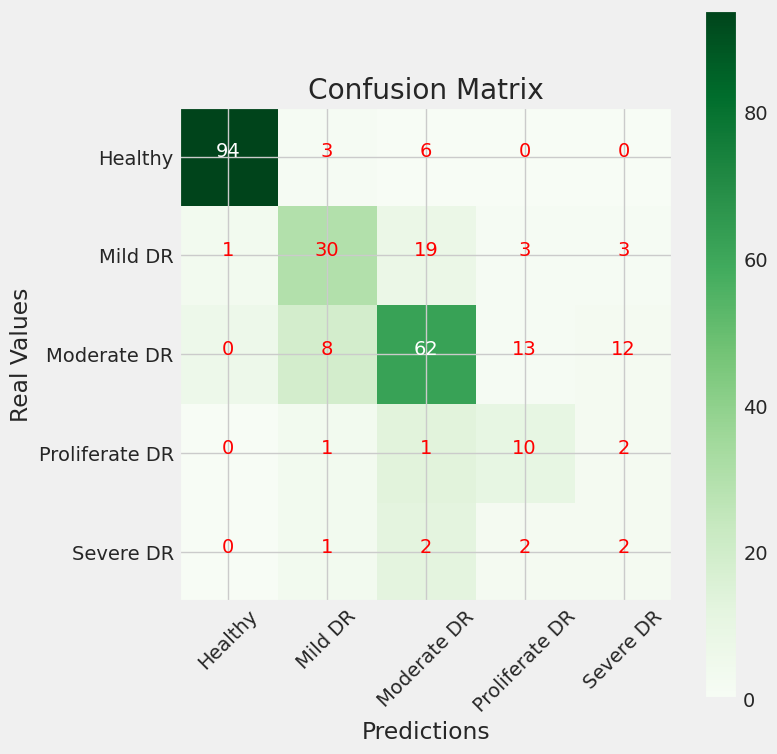

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Classification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.91      0.99      0.95        95
       Mild DR       0.54      0.70      0.61        43
   Moderate DR       0.65      0.69      0.67        90
Proliferate DR       0.71      0.36      0.48        28
     Severe DR       0.29      0.11      0.15        19

      accuracy                           0.72       275
     macro avg       0.62      0.57      0.57       275
  weighted avg       0.71      0.72      0.70       275



In [ ]:
model4.save('model4.h5')

In [ ]:
model_1 = load_model('/content/model1.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/model2.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
model_3 = load_model('/content/model3.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')
model_4 = load_model('/content/model4.h5')
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='name_of_model_4')
models = [model_1, model_2,model_3,model_4]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

ensemble_model.compile(Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc'])
epochs = 50
history=ensemble_model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)


Epoch 1/50
110/110 [==============================] - 307s 1s/step - loss: 0.0793 - acc: 0.9827 - val_loss: 1.1973 - val_acc: 0.7491
Epoch 2/50
110/110 [==============================] - 121s 1s/step - loss: 0.0587 - acc: 0.9891 - val_loss: 1.1714 - val_acc: 0.7673
Epoch 3/50
110/110 [==============================] - 122s 1s/step - loss: 0.0534 - acc: 0.9891 - val_loss: 1.1884 - val_acc: 0.7745
Epoch 4/50
110/110 [==============================] - 121s 1s/step - loss: 0.0506 - acc: 0.9891 - val_loss: 1.2336 - val_acc: 0.7600
Epoch 5/50
110/110 [==============================] - 121s 1s/step - loss: 0.0452 - acc: 0.9900 - val_loss: 1.1938 - val_acc: 0.7673
Epoch 6/50
110/110 [==============================] - 121s 1s/step - loss: 0.0484 - acc: 0.9886 - val_loss: 1.3220 - val_acc: 0.7782
Epoch 7/50
110/110 [==============================] - 121s 1s/step - loss: 0.0443 - acc: 0.9914 - val_loss: 1.3122 - val_acc: 0.7745
Epoch 8/50
110/110 [==============================] - 123s 1s/step - 

In [ ]:
# Define Vars
Train_sc = ensemble_model.evaluate(Train, verbose = 1)
Valid_sc = ensemble_model.evaluate(Valid, verbose = 1)
Test_sc =ensemble_model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 4s 254ms/step - loss: 1.4546 - acc: 0.7455
Train Scores : 
    accuracy: 0.9918181896209717 
      Loss:  0.013398931361734867 
________________________
Valid Scores : 
    accuracy: 0.7563636302947998 
      Loss:  1.724785566329956 
________________________
Test Scores : 
    accuracy: 0.7454545497894287 
      Loss:  1.454606056213379 
________________________


In [ ]:
predictions = ensemble_model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[7.3976722e-08 3.9723050e-06 2.4400529e-01 2.6245775e-06 7.5598800e-01]
 [5.3980868e-05 2.2388573e-03 7.2800845e-01 1.0811555e-04 2.6959065e-01]
 [1.0000000e+00 4.1814118e-11 3.2442707e-10 5.8900356e-13 1.3168459e-17]
 ...
 [1.5866282e-10 3.1287361e-06 8.5770798e-01 2.4574881e-08 1.4228892e-01]
 [9.9917942e-01 8.2037714e-04 1.1625448e-07 7.4417752e-09 7.8330224e-12]
 [2.9513840e-02 1.5310751e-02 9.5517266e-01 2.7017550e-06 8.6530470e-08]]
[4 2 0 2 1 0 1 1 0 0 2 0 3 0 2 2 2 2 1 0 0 2 0 2 1 1 2 2 2 2 1 0 0 1 0 0 1
 0 1 2 0 3 1 0 2 0 0 1 0 0 1 2 4 3 2 0 0 1 0 0 0 1 2 1 0 0 2 0 3 1 0 1 0 1
 2 2 3 2 2 0 1 2 1 2 2 2 2 0 1 2 0 2 2 2 0 1 2 1 1 0 2 2 4 2 2 0 2 2 2 2 2
 0 2 3 0 1 0 2 1 2 4 2 0 2 2 1 2 0 3 2 0 2 0 2 2 2 0 0 0 0 2 0 3 0 2 3 0 0
 3 2 2 4 0 0 2 0 0 2 1 2 1 2 2 0 2 0 0 0 2 2 2 2 2 0 2 2 0 0 3 1 0 0 0 2 0
 2 0 0 2 1 2 0 3 2 2 3 2 1 2 2 1 2 0 2 0 2 2 1 2 0 2 0 1 2 4 0 2 0 2 0 3 0
 2 0 1 2 3 0 2 0 0 4 0 0 0 3 2 0 2 2 0 0 0 0 1 2 0 0 4 0 0 1 1 2 0 0 0 0 1
 3 2 4 2 2 2 2 2 2 0 2 2 1 2 0 

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[94,  1,  0,  0,  0],
       [ 2, 26, 12,  2,  1],
       [ 2, 13, 71,  2,  2],
       [ 0,  1, 13, 11,  3],
       [ 1,  1, 12,  2,  3]])

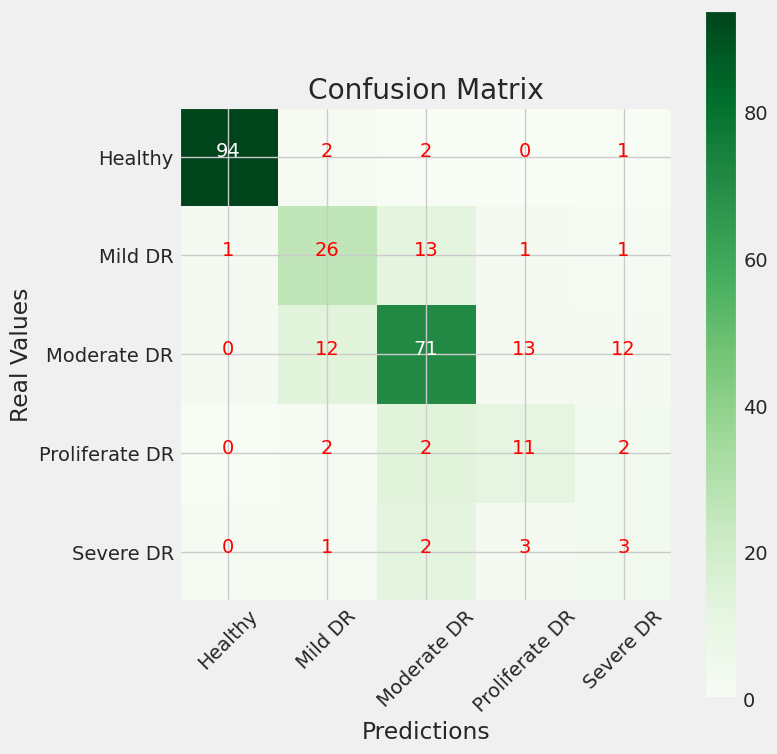

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Classification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.95      0.99      0.97        95
       Mild DR       0.62      0.60      0.61        43
   Moderate DR       0.66      0.79      0.72        90
Proliferate DR       0.65      0.39      0.49        28
     Severe DR       0.33      0.16      0.21        19

      accuracy                           0.75       275
     macro avg       0.64      0.59      0.60       275
  weighted avg       0.73      0.75      0.73       275



In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 name_of_model_1 (Functiona  (None, 5)                    1173534   ['input_5[0][0]']             
 l)                                                       8                                       
                                                                                                  
 name_of_model_2 (Functiona  (None, 5)                    2301674   ['input_5[0][0]']             
 l)                                                       1                                       
                                                                                           

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
file="Healthy.png" #change to image name
img = Image.open(file)
img = img.resize((224,224))
img_array = np.array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
# Make prediction
result = ensemble_model.predict(img_array)
result_array = result
predicted_class_index = np.argmax(result_array)
class_labels = ['Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR', 'Severe DR']
predicted_class_label = class_labels[predicted_class_index]
predicted_class_label

FileNotFoundError: [Errno 2] No such file or directory: 'Healthy.png'

In [ ]:
result_array = result
result_array

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)